# Treinar modelo de recuperação

In [1]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

import zipfile

import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

'pt_BR.utf8'

In [ ]:
# sklearn.linear_model
# import LogisticRegression

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path = env)


print("Iniciando carregamento dos dados")
zip_file = os.path.join(dataPath, 'rating_igr_25_10.zip')
z = zipfile.ZipFile(zip_file)

Iniciando carregamento dos dados


# 00) Auxiliar

In [4]:
def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

def cria_chave(row):
    return str(row['cda']) + ' - ' + str(row['id_pessoa'])

def paste_intervalo(row):
    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

def ler_bases_exportadas(nome_arquivo):
    z.extract(nome_arquivo)
    df = pd.read_csv(nome_arquivo, sep=',')
    os.remove(nome_arquivo)
    return df

# 01) Importando dados

In [5]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def read_s3(bucket_name, folder_name, file_name):
    file_key_aws = folder_name + file_name
    obj = s3.Bucket(bucket_name).Object(file_key_aws).get()
    df = pd.read_csv(obj['Body'], sep=';')
    return df

In [6]:
dados_contribuinte = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_contribuinte_prime_k4_maxpg_luan.csv')
    #'feature_store_igr_prime_ab0_maxpg.csv')

In [7]:
dados_divida = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_igr_prime_ab0_maxpg_luan.csv')
    #'feature_store_contribuinte_prime.csv') # k = 5

In [ ]:
# # Quantidade de Reparcelamento por CDA
# base_conjunta = ler_bases_exportadas('conjunta.csv')
# reparc_por_cda = base_conjunta[['cda', 'quantidade_reparcelamento']]

# dados_divida = pd.merge(dados_divida, reparc_por_cda, on = 'cda', how = 'left')
# dados_divida

In [8]:
#dados_divida = ler_bases_exportadas('conjunta_da_aberto.csv')

# 02) Processamento da feature store

In [8]:
print("Variáveis sobre as dívidas:")
print("\n", dados_divida.columns)

Variáveis sobre as dívidas:

 Index(['cda', 'tipo_divida', 'id_pessoa', 'atividade_principal', 'situacao',
       'protesto', 'idade_divida', 'da_aberto', 'valor_total_da', 'valor_pago',
       'valor_aberto', 'dif_tot_pago', 'dif_tot_pago_aberto',
       'percentual_pago_cda', 'percentual_pago_cda_faixas'],
      dtype='object')


In [9]:
print("Variáveis dos contribuintes:")
print("\n", dados_contribuinte.columns)

Variáveis dos contribuintes:

 Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
       'cpf_cnpj_existe', 'endereco_existe', 'perfil_acessivel',
       'situacao_cobranca', 'historico_pagamento_em_valor',
       'class_situacao_cobranca', 'class_contribuinte_x', 'da_aberto',
       'class_contribuinte_nome', 'class_contribuinte_perfil_x',
       'percentual_pago_cda', 'class_contribuinte_y',
       'class_contribuinte_perfil_y', 'class_contribuinte_peso'],
      dtype='object')


In [45]:
# Filtrando variáveis de interesse para a modelagem
df_divida = dados_divida[['cda', 
                          'tipo_divida',
                          'id_pessoa', 
                          'da_aberto',
                          'percentual_pago_cda', 
                          'valor_total_da', 
                          'idade_divida'#, 
                          #'quantidade_reparcelamento' 
                          ]] 




In [46]:
df_contribuinte = dados_contribuinte[['id_pessoa', 
                                      'tipo_divida',
                                      'num_dist_cda', 
                                      'quantidade_reparcelamento',
                                      #'historico_pagamento_em_qtd',
                                       'historico_pagamento_em_valor',
                                       'situacao_cobranca',
                                       'class_contribuinte_peso']]
#df_contribuinte = df_contribuinte.rename(columns = {'quantidade_reparcelamento':'total_reparc_contrib'})

In [47]:
# Trazendo dados de parcelas
#df_divida = pd.merge(df_divida, base_parcelas, 
#         on = ['cda', 'id_pessoa'], how = 'left')

df_contribuinte['quantidade_reparcelamento'] = df_contribuinte['quantidade_reparcelamento'].fillna(0)

In [48]:
# Juntar informacoes de 'divida' e 'contribuinte'
#df = pd.merge(left =df_divida, right=df_contribuinte, left_on='id_pessoa', right_on='id_pessoa')

df = pd.merge(left = df_divida, right = df_contribuinte, on=['id_pessoa', 'tipo_divida'])
df.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'da_aberto', 'percentual_pago_cda',
       'valor_total_da', 'idade_divida', 'num_dist_cda',
       'quantidade_reparcelamento', 'historico_pagamento_em_valor',
       'situacao_cobranca', 'class_contribuinte_peso'],
      dtype='object')

In [49]:
# Métricas p acompanhar
num_cda_01 = df['cda'].nunique() # hj: 1.608.610 # antes: 2.415.779
num_pessoa_01 = df['id_pessoa'].nunique() # hj: 396.691  # antes: 424.210
vlr_da_01 = df['valor_total_da'].sum() # 'R$ 17.911.603.296,66'

In [16]:
num_cda_01

1608610

In [17]:
num_pessoa_01

396691

In [18]:
vlr_da_01 = locale.currency(vlr_da_01, grouping=True)
vlr_da_01

'R$ 17.911.603.296,66'

### Valor Monetário dos dados de treino por tipo de dívida

In [19]:
df_prop_estoque = df.groupby(['tipo_divida'])['valor_total_da'].sum().to_frame().reset_index()
estoque_total = df_prop_estoque['valor_total_da'].sum()
df_prop_estoque['perc_da'] = np.round(df_prop_estoque['valor_total_da']/estoque_total, 5)


df_prop_estoque['valor_total_da'] = df_prop_estoque['valor_total_da'].apply(formatar_moeda)
df_prop_estoque

,tipo_divida,valor_total_da,perc_da
0,imovel,"R$ 8.834.946.957,13",0.49325
1,mercantil,"R$ 9.076.656.339,53",0.50675


In [20]:
df.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'da_aberto', 'percentual_pago_cda',
       'valor_total_da', 'idade_divida', 'num_dist_cda',
       'quantidade_reparcelamento', 'historico_pagamento_em_valor',
       'situacao_cobranca', 'class_contribuinte_peso'],
      dtype='object')

In [50]:
data_percentil = {
    'inf': [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1],
    'sup': [0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
}

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)
df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)

# Define the bins and labels for groups
igr_bins = [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
igr_labels = df_cut_percentil['intervalo']

df['percentual_pago_cda_faixas'] = pd.cut(df['percentual_pago_cda'],
                                bins = igr_bins,
                                labels = igr_labels,
                                right = False)

In [51]:
df_metrics = df.groupby('percentual_pago_cda_faixas')['percentual_pago_cda_faixas'].count().to_frame()
total = df_metrics['percentual_pago_cda_faixas'].sum()  
df_metrics['total'] = total
df_metrics['perc'] = np.round(df_metrics['percentual_pago_cda_faixas']/total, 4)
df_metrics

,percentual_pago_cda_faixas,total,perc
percentual_pago_cda_faixas,,,
"[0.0, 0.01)",1678511,2624920,0.6395
"[0.01, 0.25)",281298,2624920,0.1072
"[0.25, 0.5)",147046,2624920,0.0560
"[0.5, 0.75)",81669,2624920,0.0311
"[0.75, 0.99)",4104,2624920,0.0016
"[0.99, 1.0)",3,2624920,0.0000
"[1.0, 1.01)",432289,2624920,0.1647


# Filtrando os últimos 15 anos

In [52]:
df.shape[0]

2624920

In [53]:
# CDAs que vamos treinar
da_aberto_0 = df[df['da_aberto'] == 0]
da_aberto_0.shape[0]

2624920

In [72]:
# Filtrando apenas dados recentes para treinamento
df = da_aberto_0.query("idade_divida < 10")

In [73]:
df.shape[0] # 10 anos: 1.720.128 # 15 anos: 2.061.060

1545215

In [74]:
df_metrics2 = df.groupby('percentual_pago_cda_faixas')['percentual_pago_cda_faixas'].count().to_frame()
total2 = df_metrics2['percentual_pago_cda_faixas'].sum()  
df_metrics2['perc'] = np.round(df_metrics2['percentual_pago_cda_faixas']/total2, 4)
df_metrics2

,percentual_pago_cda_faixas,perc
percentual_pago_cda_faixas,,
"[0.0, 0.01)",1053862,0.6820
"[0.01, 0.25)",117171,0.0758
"[0.25, 0.5)",52348,0.0339
"[0.5, 0.75)",51615,0.0334
"[0.75, 0.99)",1903,0.0012
"[0.99, 1.0)",0,0.0000
"[1.0, 1.01)",268316,0.1736


### Filtrando p os últimos 15 anos: 19% dos dados entre 0 e 1

In [75]:
# Estoque considerando os últimos 10 anos
est_15anos = df['valor_total_da'].sum()
est_15anos = locale.currency(est_15anos, grouping=True)
est_15anos # 'R$ 5.992.946.539,56'

'R$ 5.444.899.546,47'

In [ ]:
# print("Informações sobre o dataframe:\n")
# df.info()

# print("\nEstatísticas descritivas:")
# df.describe().T

In [ ]:
# # Para retirar variáveis que não serão usadas no modelo:
# # Vou criar uma chave auxiliar - just in case

# df['chave_aux'] = df.apply(cria_chave, axis = 1)
# # Definir a coluna 'chave_aux' como índice
# df.set_index('chave_aux', inplace=True)
# df

In [58]:
df.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'da_aberto', 'percentual_pago_cda',
       'valor_total_da', 'idade_divida', 'num_dist_cda',
       'quantidade_reparcelamento', 'historico_pagamento_em_valor',
       'situacao_cobranca', 'class_contribuinte_peso',
       'percentual_pago_cda_faixas'],
      dtype='object')

In [76]:
# Retirando variáveis que não serão usadas no modelo
df_feature_store = df.drop(columns=['da_aberto', 'percentual_pago_cda_faixas'])
df_feature_store = df_feature_store.set_index(['cda', 'tipo_divida', 'id_pessoa'])

In [77]:
df_feature_store.isnull().sum()

percentual_pago_cda             0
valor_total_da                  0
idade_divida                    0
num_dist_cda                    0
quantidade_reparcelamento       0
historico_pagamento_em_valor    0
situacao_cobranca               0
class_contribuinte_peso         0
dtype: int64

# 03) Visualizando a variável target

In [78]:
matriz_correlacao = df_feature_store.corr()

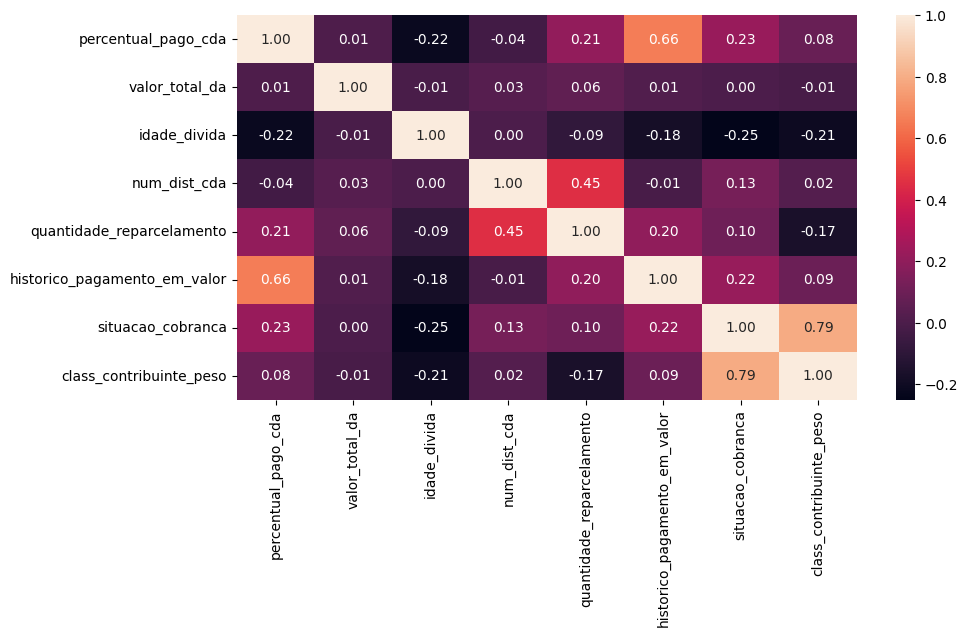

In [79]:
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

# 04) Definindo pipeline de treinamento dos modelos

In [80]:
seed = 1337 # Semente fixando a aleatoridade dos experimentos

In [81]:
df_feature_store['percentual_pago_cda'].mean()

0.21693905291570187

In [82]:
y = df_feature_store['percentual_pago_cda']
x = df_feature_store.drop(columns=['percentual_pago_cda'])

In [83]:
x.columns

Index(['valor_total_da', 'idade_divida', 'num_dist_cda',
       'quantidade_reparcelamento', 'historico_pagamento_em_valor',
       'situacao_cobranca', 'class_contribuinte_peso'],
      dtype='object')

In [84]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=seed, test_size=0.3)

In [85]:
def roda_pipeline(algoritmo_normalizador, algoritmo_regressao, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([('scaler', algoritmo_normalizador), ('regressor', algoritmo_regressao)])
    pipeline.fit(X_train, y_train)

    previsoes = pipeline.predict(X_test)

    r2 = r2_score(y_test, previsoes)
    mse = mean_squared_error(y_test, previsoes)
    
    print("\nModelo treinado:", str(algoritmo_regressao))
    print("R2 ->", r2)
    print("MSE ->", mse)

In [86]:
biblioteca_modelos = {
    'dummy': DummyRegressor(), # Dados dummy - Usado para baseline
    'random_forest': RandomForestRegressor(random_state=seed)
}

pipeline_modelos = ['dummy','random_forest']

# 05) Executando o experimento de treinamento do modelo

In [87]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritmo_normalizador= StandardScaler(),
        algoritmo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -2.135555953408641e-06
MSE -> 0.14692390712187184

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.7115841063843306
MSE -> 0.04237509947166433


In [88]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritmo_normalizador= MinMaxScaler(),
        algoritmo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
        )


Modelo treinado: DummyRegressor()
R2 -> -2.135555953408641e-06
MSE -> 0.14692390712187184

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.7175842652709842
MSE -> 0.041493534567316345


In [89]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritmo_normalizador= RobustScaler(),
        algoritmo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -2.135555953408641e-06
MSE -> 0.14692390712187184

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.7115805915621658
MSE -> 0.04237561588196679


**Conclusão:** 
- Adotar StandardScaler

# 06) Realizando previsões com o melhor modelo

In [90]:
normalizador = StandardScaler() #RobustScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)

colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [91]:
x_norm = df_normalizado

In [92]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y, random_state=seed, test_size=0.3)

In [93]:
best_model = RandomForestRegressor(random_state=seed)
best_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1337)

In [94]:
predict_test = best_model.predict(X_test)

r2 = r2_score(y_test, predict_test)
mse = mean_squared_error(y_test, predict_test)

print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("MSE ->", mse)

Métricas de validação do modelo:
R2 -> 0.7115067180790615
MSE -> 0.04238646963955837


In [95]:
best_model.get_params() # Parâmetros utilizados

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1337,
 'verbose': 0,
 'warm_start': False}

In [96]:
variaveis_preditoras = best_model.feature_names_in_
importancia_variaveis = best_model.feature_importances_

print("Variáveis preditoras:")
print('\n', variaveis_preditoras)

Variáveis preditoras:

 ['valor_total_da' 'idade_divida' 'num_dist_cda'
 'quantidade_reparcelamento' 'historico_pagamento_em_valor'
 'situacao_cobranca' 'class_contribuinte_peso']


In [97]:
dados_features = {
    'features': variaveis_preditoras,
    'importancia': importancia_variaveis
}
matriz_importancia = pd.DataFrame(dados_features).sort_values('importancia', ascending=False).reset_index(drop='index')
matriz_importancia

,features,importancia
0,historico_pagamento_em_valor,0.477206
1,valor_total_da,0.333997
2,idade_divida,0.072912
3,num_dist_cda,0.042189
4,quantidade_reparcelamento,0.033556
5,situacao_cobranca,0.029219
6,class_contribuinte_peso,0.010922


In [98]:
# Realizando predições para avaliações do modelo

previsoes_norm = best_model.predict(x_norm)

In [99]:
# Gerando resíduos da predição (observado - previsão)
df_feature_store['y_predict'] = previsoes_norm
df_feature_store['residuos'] =  df_feature_store['percentual_pago_cda'] - df_feature_store['y_predict']

In [100]:
df_feature_store['percentual_pago_cda'].describe()

count    1.545215e+06
mean     2.169391e-01
std      3.829342e-01
min      1.220188e-07
25%      6.050009e-04
50%      1.444106e-03
75%      2.081906e-01
max      1.000000e+00
Name: percentual_pago_cda, dtype: float64

In [102]:
df_feature_store['y_predict'].describe()

count    1.545215e+06
mean     2.161291e-01
std      3.499537e-01
min      3.370840e-05
25%      6.669914e-04
50%      2.382881e-03
75%      2.981125e-01
max      1.000000e+00
Name: y_predict, dtype: float64

In [103]:
resid = df_feature_store[['y_predict', 'percentual_pago_cda', 'residuos']]
resid = resid.sort_values(by = 'residuos', ascending = False)
resid_not0 = resid[resid['y_predict'] != 0]
resid_not0_not1 = resid_not0[resid_not0['y_predict'] != 1]
resid_not0_not1

,,,y_predict,percentual_pago_cda,residuos
cda,tipo_divida,id_pessoa,,,
ec6f0a85a8f2be8f18565e26094f06ee2,mercantil,839f1317177ae5e7,0.000208,1.000000,0.999792
bc855d3af61def3b9fcacff532cf50c4,mercantil,d2f6ecc0f7a02333,0.000253,1.000000,0.999747
b761861e2e46f25cb5eae1a923f0f8701,imovel,8c228c2b086d260a,0.000257,1.000000,0.999743
43d9910680a9e4e79989bae6f4af91ee1,imovel,fc6189ba8a14366b,0.000259,1.000000,0.999741
81eb3dea2cec3ada18565e26094f06ee1,imovel,f2d10cbf07707970,0.000263,1.000000,0.999737
...,...,...,...,...,...
4451d2d0d30a77954bd01ecb8277da0b1,imovel,803b626e478f0a75,0.992674,0.000457,-0.992218
aaa396b59eb9cd84b5eae1a923f0f8701,imovel,067077f1afcda8de,0.993159,0.000831,-0.992327
c4180c1931e6dd0918565e26094f06ee1,imovel,b6178341b61f3c1b,0.994777,0.000310,-0.994468


In [109]:
data_percentil = {
    'inf': [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75],
    'sup': [-0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
}
[-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)
df_cut_percentil 

,inf,sup,intervalo
0,-1.00,-0.75,"[-1.0, -0.75)"
1,-0.75,-0.50,"[-0.75, -0.5)"
2,-0.50,-0.25,"[-0.5, -0.25)"
3,-0.25,-0.20,"[-0.25, -0.2)"
4,-0.20,-0.15,"[-0.2, -0.15)"
5,-0.15,-0.10,"[-0.15, -0.1)"
6,-0.10,-0.05,"[-0.1, -0.05)"
7,-0.05,0.00,"[-0.05, 0.0)"
8,0.00,0.05,"[0.0, 0.05)"
9,0.05,0.10,"[0.05, 0.1)"


In [110]:
resid

,,,y_predict,percentual_pago_cda,residuos,resid_faixas
cda,tipo_divida,id_pessoa,,,,
ec6f0a85a8f2be8f18565e26094f06ee2,mercantil,839f1317177ae5e7,0.000208,1.000000,0.999792,"[1.0, 2.0)"
bc855d3af61def3b9fcacff532cf50c4,mercantil,d2f6ecc0f7a02333,0.000253,1.000000,0.999747,"[1.0, 2.0)"
b761861e2e46f25cb5eae1a923f0f8701,imovel,8c228c2b086d260a,0.000257,1.000000,0.999743,"[1.0, 2.0)"
43d9910680a9e4e79989bae6f4af91ee1,imovel,fc6189ba8a14366b,0.000259,1.000000,0.999741,"[1.0, 2.0)"
81eb3dea2cec3ada18565e26094f06ee1,imovel,f2d10cbf07707970,0.000263,1.000000,0.999737,"[1.0, 2.0)"
...,...,...,...,...,...,...
0d76a828c4a075476b3a8e268c80aedf1,imovel,9de94a162e7e719c,1.000000,0.000588,-0.999412,"[-2.0, -1.0)"
1fdaa5b097a143609989bae6f4af91ee1,imovel,97ca6387b12f76ac,1.000000,0.000587,-0.999413,"[-2.0, -1.0)"
95fbe3c3fd43a9f12b46f673bf0c61251,imovel,2b03234c576ed18d,1.000000,0.000586,-0.999414,"[-2.0, -1.0)"


In [112]:
# Define the bins and labels for groups
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
df_summary_residuos = resid.groupby('resid_faixas')['resid_faixas'].count().to_frame()
total = df_summary_residuos['resid_faixas'].sum()
df_summary_residuos['perc'] = np.round(df_summary_residuos['resid_faixas']/total, 5)
df_summary_residuos  

,resid_faixas,perc
resid_faixas,,
"[-1.0, -0.75)",2540,0.00164
"[-0.75, -0.5)",7370,0.00477
"[-0.5, -0.25)",27253,0.01764
"[-0.25, -0.2)",16221,0.01050
"[-0.2, -0.15)",22900,0.01482
"[-0.15, -0.1)",36978,0.02393
"[-0.1, -0.05)",65485,0.04238
"[-0.05, 0.0)",613224,0.39685
"[0.0, 0.05)",608010,0.39348


In [113]:
#df_summary_residuos = resid.groupby('y_faixas')['y_faixas'].count().to_frame()#.reset_index()
df_summary_residuos = df_summary_residuos.rename(columns = {'resid_faixas':'freq'})
df_summary_residuos = df_summary_residuos.reset_index()
df_summary_residuos

,resid_faixas,freq,perc
0,"[-1.0, -0.75)",2540,0.00164
1,"[-0.75, -0.5)",7370,0.00477
2,"[-0.5, -0.25)",27253,0.01764
3,"[-0.25, -0.2)",16221,0.01050
4,"[-0.2, -0.15)",22900,0.01482
5,"[-0.15, -0.1)",36978,0.02393
6,"[-0.1, -0.05)",65485,0.04238
7,"[-0.05, 0.0)",613224,0.39685
8,"[0.0, 0.05)",608010,0.39348
9,"[0.05, 0.1)",36272,0.02347


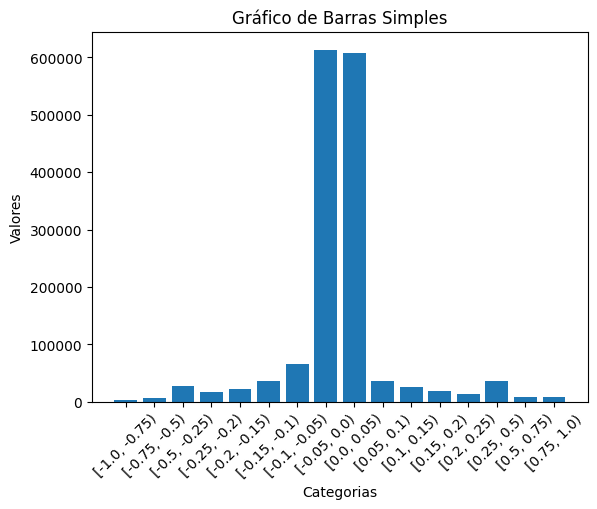

In [114]:
# import matplotlib.pyplot as plt

# # Dados para o gráfico de barras
categorias = df_summary_residuos['resid_faixas']
valores = df_summary_residuos['freq']

# # Criar o gráfico de barras
plt.bar(categorias, valores)

# # Adicionar rótulos ao gráfico
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Simples')

plt.xticks(rotation=45)

# # Exibir o gráfico
plt.show()

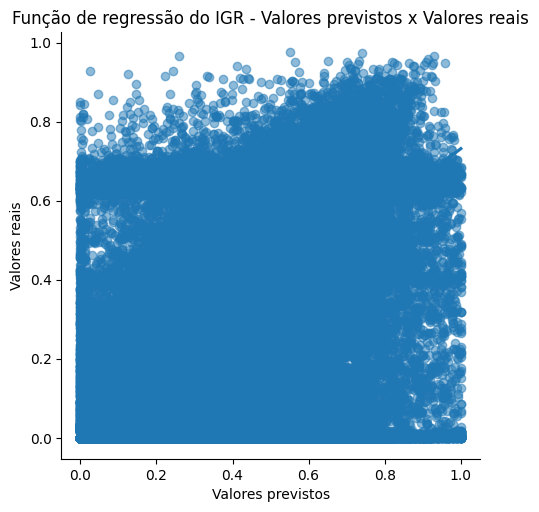

In [115]:
# Todos os pontos
df_regressao = df_feature_store.query("percentual_pago_cda != 1").query("percentual_pago_cda != 0")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

In [119]:
resid['residuos'].describe()

count    1.545215e+06
mean     8.099677e-04
std      1.298335e-01
min     -9.996943e-01
25%     -1.042872e-06
50%     -1.301043e-18
75%      4.748583e-10
max      9.997924e-01
Name: residuos, dtype: float64

In [116]:
resid['residuos'].std()

0.12983351483153266

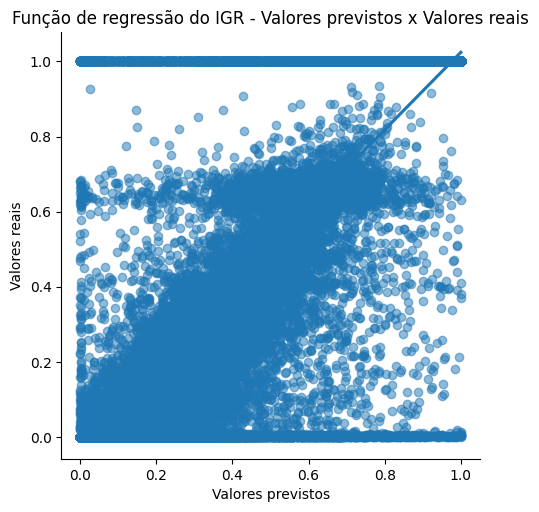

In [120]:
# Amostras
df_regressao = resid.sample(n=140000)

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()


# Atenção, Larissa

### Calcular um tamanho de amostra n para amostrar os resíduos

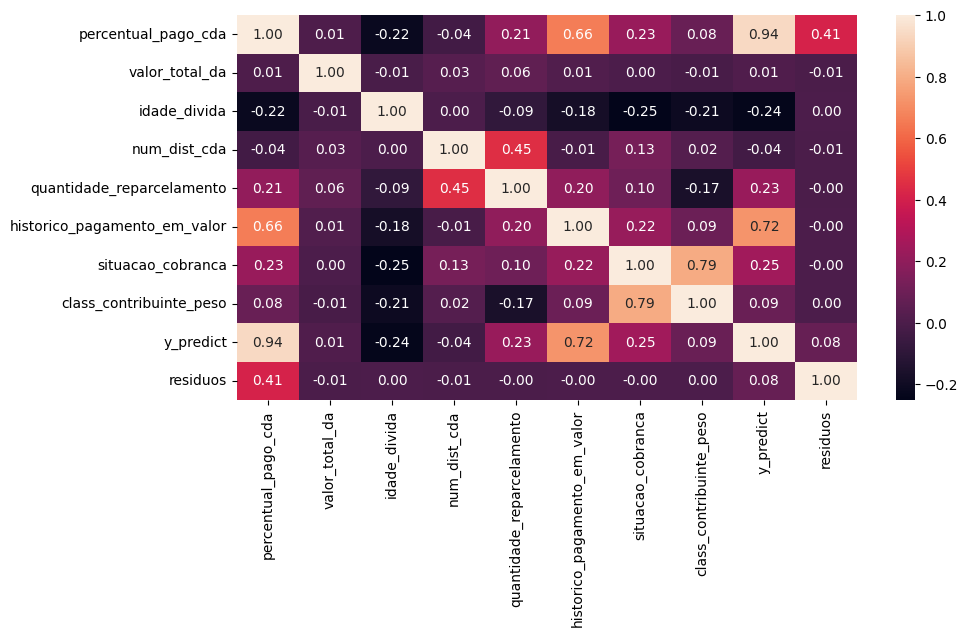

In [121]:
matriz_corr_regressao = df_feature_store.corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_corr_regressao, annot = True, fmt = ".2f")
plt.show()

In [122]:
df_feature_store['residuos'].describe()

count    1.545215e+06
mean     8.099677e-04
std      1.298335e-01
min     -9.996943e-01
25%     -1.042872e-06
50%     -1.301043e-18
75%      4.748583e-10
max      9.997924e-01
Name: residuos, dtype: float64

In [123]:
data_percentil = {
    'inf': [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1],
    'sup': [0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
}

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)

# Define the bins and labels for groups
igr_bins = [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
igr_labels = df_cut_percentil['intervalo']

resid['ypred_faixas'] = pd.cut(resid['y_predict'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)
                            
resid['y_faixas'] = pd.cut(resid['percentual_pago_cda'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
contingency_table = pd.crosstab(resid['y_faixas'], resid['ypred_faixas'])
contingency_table   

ypred_faixas,"[0.0, 0.01)","[0.01, 0.25)","[0.25, 0.5)","[0.5, 0.75)","[0.75, 0.99)","[0.99, 1.0)","[1.0, 1.01)"
y_faixas,,,,,,,
"[0.0, 0.01)",862594,164866,18587,5534,2145,51,85
"[0.01, 0.25)",994,91689,20972,2713,755,20,28
"[0.25, 0.5)",204,5599,35865,9534,1108,12,26
"[0.5, 0.75)",273,1522,8428,38089,3263,26,14
"[0.75, 0.99)",12,62,168,1038,623,0,0
"[1.0, 1.01)",1902,5718,6954,32042,88293,7920,125487


# 07) Salvando o melhor modelo

In [124]:
def salva_modelo_serializado(nome_modelo_serializado, modelo):
    sav_best_model = open(nome_modelo_serializado, 'wb')
    pickle.dump(modelo, sav_best_model)
    sav_best_model.close()

    pathModelo = modelsPath+"\\"+os.path.join(nome_modelo_serializado)
    shutil.move(os.path.abspath(nome_modelo_serializado), pathModelo)

In [125]:
salva_modelo_serializado("modeloDA-igr-divida-prime_maxpg.pkl", best_model)